In [10]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from numpy import linalg
import warnings
from scipy.optimize import minimize
from scipy.optimize import minimize_scalar
from scipy.optimize import differential_evolution

warnings.filterwarnings('ignore')
font_name = matplotlib.font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
krfont = {'family':font_name, 'size':10}
matplotlib.rc('font', **krfont)
matplotlib.rcParams['axes.unicode_minus'] = False
np.random.seed(20180609)

In [2]:
# Data Import
z = np.array(pd.read_csv('./data/KIS_spot_continuous_montly_201612.csv').T)

In [182]:
class NelsonSiegel:
    def __init__(self, lambda_, tau, z):
        self.lambda_ = lambda_
        self.tau = tau
        self.z = z
        H = np.array([[1, (1-np.exp(-lambda_*t))/(lambda_*t), (1-np.exp(-lambda_*t))/(lambda_*t) - np.exp(-lambda_*t)] for t in tau])
        self.__beta = np.dot(np.dot(linalg.inv(np.dot(H.T,H)),H.T), z)
        return None
    
    def __Objective(self, lambda_):
        tau = self.tau
        H = np.array([[1, (1-np.exp(-lambda_*t))/(lambda_*t), (1-np.exp(-lambda_*t))/(lambda_*t) - np.exp(-lambda_*t)] for t in tau])
        beta = np.dot(np.dot(linalg.inv(np.dot(H.T,H)),H.T), self.z)
        error = np.sum((z0-np.dot(H, beta))**2)
        return error
    
    def getBeta(self):
        return self.__beta
    
    def calcLambda(self):
        res = minimize_scalar(self.__Objective, method='bounded', bounds=(1e-5,1))
        return res.x
    
    def setLambda(self, lambda_):
        self.lambda_ = lambda_
        tau = self.tau
        H = np.array([[1, (1-np.exp(-lambda_*t))/(lambda_*t), (1-np.exp(-lambda_*t))/(lambda_*t) - np.exp(-lambda_*t)] for t in tau])
        self.__beta = np.dot(np.dot(linalg.inv(np.dot(H.T,H)),H.T), self.z)
        return None
    
    def YieldCurve(self, t):
        h = np.array([[1, (1-np.exp(-lambda_*t))/(lambda_*t), (1-np.exp(-lambda_*t))/(lambda_*t) - np.exp(-lambda_*t)]])
        r = np.dot(h, self.__beta)[0][0]
        return r

In [183]:
lambda_ = 0.3
tau = [0.25,0.5,0.75,1,1.5,2,2.5,3,5,7,10,15,20]
z0 = z[:,0].reshape(z.shape[0],1)
ns = NelsonSiegel(lambda_, tau, z0)

In [184]:
ns.setLambda(ns.calcLambda())

In [48]:
# Initial State
def OptimLambda(lambda_):
    z0 = z[:,0].reshape(z.shape[0],1)
    tau = [0.25,0.5,0.75,1,1.5,2,2.5,3,5,7,10,15,20]
    H = np.array([[1, (1-np.exp(-lambda_*t))/(lambda_*t), (1-np.exp(-lambda_*t))/(lambda_*t) - np.exp(-lambda_*t)] for t in tau])
    beta = np.dot(np.dot(linalg.inv(np.dot(H.T,H)),H.T),z0)
    error = np.sum((z0-np.dot(H,beta))**2)
    return beta, error

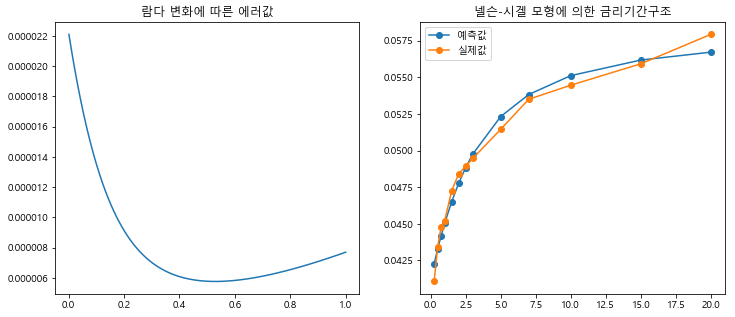

람다 : 0.5296
초기값 : L=0.0583, S=-0.0171, C=0.0000


In [95]:
# Lambda Optimization
res = minimize_scalar(lambda x:OptimLambda(x)[1], method='bounded', bounds=(1e-5,1))
lambda_ = res.x

plt.figure(figsize=(12,5))

plt.subplot(121)
u = np.linspace(0.001,1,100)
v = list(map(lambda x:OptimLambda(x)[1], u))
plt.plot(u,v)
plt.title('람다 변화에 따른 에러값')

plt.subplot(122)
z0 = z[:,0].reshape(z.shape[0],1)
tau = [0.25,0.5,0.75,1,1.5,2,2.5,3,5,7,10,15,20]
H = np.array([[1, (1-np.exp(-lambda_*t))/(lambda_*t), (1-np.exp(-lambda_*t))/(lambda_*t) - np.exp(-lambda_*t)] for t in tau])
beta = OptimLambda(res.x)[0]  
    
w = np.dot(H,beta)
plt.plot(tau,w, '-o', label='예측값')
plt.plot(tau,z0, '-o', label='실제값')
plt.title('넬슨-시겔 모형에 의한 금리기간구조')
plt.legend()

plt.show()


print('람다 : {:.4f}'.format(res.x))
print('초기값 : L={:.4f}, S={:.4f}, C={:.4f}'.format(OptimLambda(res.x)[0][0][0],OptimLambda(res.x)[0][1][0],OptimLambda(res.x)[0][2][0]))

In [3]:
# Defining The Kalman Filter Class

class KalmanFilter:
    def __init__(self, A, B, Q, H, R):
        # 초기화
        self.A = A
        self.B = B
        self.Q = Q
        self.H = H
        self.R = R
    
    def Predict(self, inputs):
        x, P = inputs
        x_pred = np.dot(self.A,x)
        P_pred = np.dot(np.dot(self.A,P),self.A.T) + self.Q
        z_pred = np.dot(self.H, x_pred)
        return x_pred, P_pred, z_pred

    def Update(self, update, z_meas):
        x_pred, P_pred, z_pred = update
        v = z_meas - z_pred
        F = np.dot(np.dot(self.H, P_pred),self.H.T) + self.R
        K = np.dot(np.dot(P_pred, self.H.T), linalg.inv(F))
        x_update = x_pred + np.dot(K, v)
        P_update = P_pred - np.dot(np.dot(K, self.H), P_pred)
        dF = max(linalg.det(F),1e-10)
        logl = (-0.5*np.log(2*np.pi) - 0.5*np.log(dF) - 0.5*np.dot(np.dot(v.T, linalg.inv(F)),v))[0][0]
        return x_update, P_update, logl
    
    def __Next(self, x0):
        m = self.Q.shape[0]
        l = self.R.shape[0]
        x = np.dot(self.A,x0)+self.B + np.random.multivariate_normal(mean=np.zeros(m), cov=self.Q).reshape(m,1)
        z = np.dot(H,x) + np.random.multivariate_normal(mean=np.zeros(l), cov=self.R).reshape(l,1)
        return x, z
    
    def Generate(self, x, n=1):
        for i in range(n):
            if i == 0:
                xstack, zstack = self.__Next(x)
                x = xstack
                continue
            x, z = self.__Next(x)
            xstack = np.concatenate((xstack, x), axis=1)
            zstack = np.concatenate((zstack, z), axis=1)
        return xstack, zstack

In [4]:
# Objective Function

def ObjectiveKF(param, x0, P0, z):
    
    dt = 1/12
    tau = [0.25,0.5,0.75,1,1.5,2,2.5,3,5,7,10,15,20]
    theta1, theta2, theta3, k1, k2, k3, sigma1, sigma2, sigma3, rho12, rho13, rho23, e, lambda_ = param
    
    # 입력변수들을 State-Measurement 방정식에 입력
    A = np.array([[1-k1*dt,0,0],
                  [0,1-k2*dt,0],
                  [0,0,1-k3*dt]])
    B = np.array([[k1*theta1],
                  [k2*theta2],
                  [k3*theta3]])*dt
    Q = np.array([[sigma1**2, sigma1*sigma2*rho12, sigma1*sigma3*rho13],
                  [sigma2*sigma1*rho12, sigma2**2, sigma2*sigma3*rho23],
                  [sigma3*sigma1*rho13, sigma3*sigma2*rho23, sigma3**2]])
    H = np.array([[1, (1-np.exp(-lambda_*t))/(lambda_*t), (1-np.exp(-lambda_*t))/(lambda_*t) - np.exp(-lambda_*t)] for t in tau])
    R = np.identity(len(tau))*e
    
    # Kalman Filter 객체 생성
    kf = KalmanFilter(A,B,Q,H,R)
    
    # 초기값 입력
    xf, Pf = x0, P0
    
    # 필터링 및 Log-likelihood 스택 쌓기
    loglstack = []
    for k in [z[:,i] for i in range(z.shape[1])]:
        xf, Pf, logl = kf.Update(kf.Predict([xf,Pf]), k.reshape(z.shape[0],1))
        loglstack.append(logl)
        
    # The total sum of log-likelihood
    return sum(loglstack)

In [71]:
# Input Initial State 

x0 = OptimLambda(res.x)[0]
P0 = np.array([[0.1, 0, 0],
               [0, 0.1, 0],
               [0, 0, 0.001]])

In [72]:
# Optimization of Multi-variables

param = np.array([6.99e-01,9.86e-04,9.76e-01,1.04e+00,1.04,1.03,1.01,1.02,0.91,1.00,0.146,0.11,0.00018,0.7])
res = minimize(lambda p:-ObjectiveKF(p, x0=x0,P0=P0,z=z), param, method='nelder-mead', options={'xtol':1e-16})

In [ ]:
# Differential Evolution

bounds = [(0,1),(0,1),(0,1),(0,1),(0,1),(0,1),(0,1),(0,1),(0,1),(-1,1),(-1,1),(-1,1),(0,0.001),(0,1)]
res = differential_evolution(lambda p:-ObjectiveKF(p, x0=x0,P0=P0,z=z), bounds)

In [9]:
# Filtering

dt = 1/12
tau = [0.25,0.5,0.75,1,1.5,2,2.5,3,5,7,10,15,20]
theta1, theta2, theta3, k1, k2, k3, sigma1, sigma2, sigma3, rho12, rho13, rho23, e, lambda_ = res.x

# 입력변수들을 State-Measurement 방정식에 입력
A = np.array([[1-k1*dt,0,0],
              [0,1-k2*dt,0],
              [0,0,1-k3*dt]])
B = np.array([[k1*theta1],
              [k2*theta2],
              [k3*theta3]])*dt
Q = np.array([[sigma1**2, sigma1*sigma2*rho12, sigma1*sigma3*rho13],
              [sigma2*sigma1*rho12, sigma2**2, sigma2*sigma3*rho23],
              [sigma3*sigma1*rho13, sigma3*sigma2*rho23, sigma3**2]])
H = np.array([[1, (1-np.exp(-lambda_*t))/(lambda_*t), (1-np.exp(-lambda_*t))/(lambda_*t) - np.exp(-lambda_*t)] for t in tau])
R = np.identity(len(tau))*e

kf = KalmanFilter(A,B,Q,H,R)
xf, Pf = x0, P0
xstack = xf
zstack = []
for k in [z[:,i] for i in range(z.shape[1])]:
    pred = kf.Predict([xf,Pf])
    zstack.append(pred[2])
    xf, Pf, _ = kf.Update(pred, k.reshape(z.shape[0],1))
    xstack = np.concatenate((xstack, xf), axis=1)

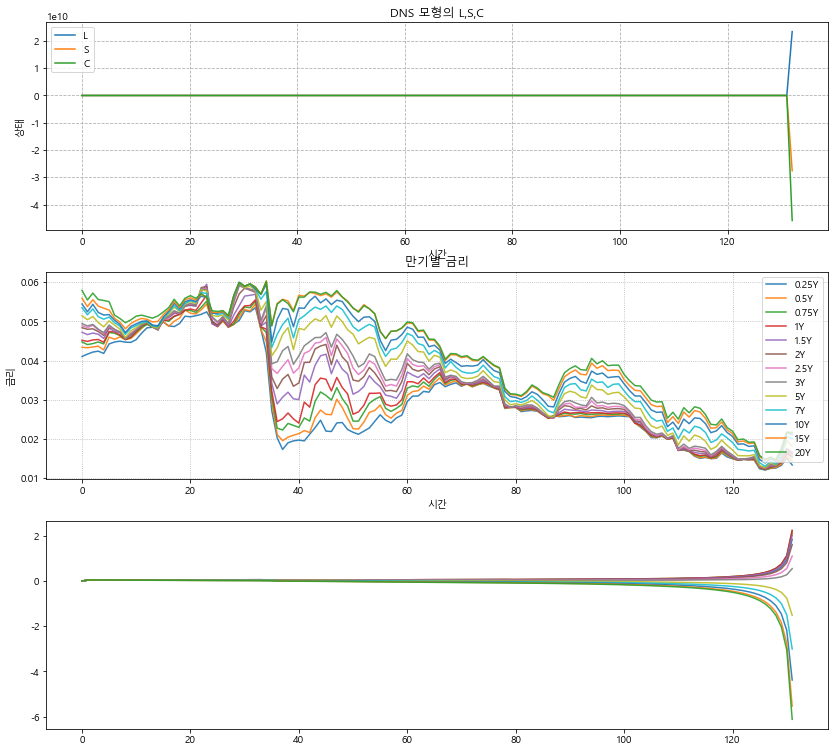

In [45]:
# Graph

fig, ax = plt.subplots(3,1, figsize=(14,13))

ax[0].plot(xstack[0,:], '-', label='L')
ax[0].plot(xstack[1,:], '-', label='S')
ax[0].plot(xstack[2,:], '-', label='C')
ax[0].legend()
ax[0].set_xlabel('시간')
ax[0].set_ylabel('상태')
ax[0].set_title('DNS 모형의 L,S,C')
ax[0].grid(True, linestyle='--')

z2 = np.array(zstack).reshape((132,13)).T

for i in range(len(tau)):
    ax[1].plot(z[i,:], '-', label='{:}Y'.format(tau[i]), alpha=0.9)
    ax[2].plot(z2[i,:], '-', label='{:}Y'.format(tau[i]), alpha=0.9)
ax[1].set_xlabel('시간')
ax[1].set_ylabel('금리')
ax[1].legend(loc='upper right')
ax[1].set_title('만기별 금리')
ax[1].grid(True, linestyle=':')

plt.show()